In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_UCB1_Small_Graphs import Dist_UCB1
from Dist_KL_UCB_Small_Graphs import Dist_KL_UCB
from Dist_UCB import Dist_UCB
import os
from multiprocess import Pool

n_runs = 10
T = 10000
G1 = nx.complete_graph(6)
G2 = nx.cycle_graph([6,7,8,9,10,11])
G = nx.compose(G1,G2)
N = G.number_of_nodes()

nodes = list(G.nodes)
for i in nodes:
    G.add_edge(i,i)

rwd_means = [.2, .3, .4, .5, .6]
betas = [1, 1, 1, 0.01, 0.01, 0.01, 1, 1, 1, 0.01, 0.01, 0.01]
sigmas = [1, 1, 1, 0.01, 0.01, 0.01, 1, 1, 1, 0.01, 0.01, 0.01]
seeds = [i for i in range(n_runs)]

In [60]:
def worker(job_runs, seeds, betas, T, N, G):
    regrets_dist_ucb1 = np.zeros((len(job_runs), N, T))
    for run in job_runs:
        start_run_t = time.time()
        
        sd = 0.1
        distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
        for n in range(N):
            for i in range(len(rwd_means)):
                distributions[n][i].random_state = np.random.RandomState(seed=seeds[run])
        
        distucb1 = Dist_UCB1(T, distributions, G, beta=betas)
        distucb1.run()
        regrets_dist_ucb1[run-job_runs[0], :, :] = distucb1.regrets
        
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return regrets_dist_ucb1

In [61]:
def worker_kl(job_runs, seeds, sigmas, T, N, G):
    regrets_dist_kl_ucb = np.zeros((len(job_runs), N, T))
    for run in job_runs:
        start_run_t = time.time()
        
        sd = 0.1
        kl_distributions = [sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))]
        for i in range(len(rwd_means)):
            kl_distributions[i].random_state = np.random.RandomState(seed=seeds[run])
        distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
        for n in range(N):
            for i in range(len(rwd_means)):
                distributions[n][i].random_state = np.random.RandomState(seed=seeds[run])
        
        distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas)
        distkl.run()
        regrets_dist_kl_ucb[run-job_runs[0], :, :] = distkl.regrets
        
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return regrets_dist_kl_ucb

In [62]:
def worker_ucb(job_runs, seeds, T, N, G):
    regrets_dist_ucb = np.zeros((len(job_runs), N, T))
    for run in job_runs:
        start_run_t = time.time()
        
        sd = 0.1
        distributions = [[sps.truncnorm(a=(0-rwd_means[i])/sd, b=(1-rwd_means[i])/sd, loc=rwd_means[i], scale=sd) for i in range(len(rwd_means))] for n in range(N)]
        for n in range(N):
            for i in range(len(rwd_means)):
                distributions[n][i].random_state = np.random.RandomState(seed=seeds[run])
        
        distucb = Dist_UCB(T, distributions, G)
        distucb.run()
        regrets_dist_ucb[run-job_runs[0], :, :] = distucb.regrets
        
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return regrets_dist_ucb

In [63]:
regrets_dist_ucb1 = np.zeros((n_runs, N, T))
init_time = time.time()
cpus = os.cpu_count()
init_time = time.time()

pool = Pool()
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, betas, T, N, G) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
regrets_dist_ucb1_unconcat = [result for result in results]
np.concatenate(regrets_dist_ucb1_unconcat, out=regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb1 = np.mean(regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:109: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB1_Small_Graphs.py:109: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 0 in 97.89493227005005sec
finished run 5 in 98.1765706539154sec
finished run 1 in 106.50253129005432sec
finished run 6 in 106.23282623291016sec
finished run 7 in 75.69819641113281sec
finished run 2 in 75.8468017578125sec
finished run 3 in 73.35755062103271sec
finished run 8 in 74.04848265647888sec
finished run 9 in 74.09994578361511sec
finished run 4 in 74.71784090995789sec
Total run time = 428.5594379901886sec


In [64]:
regrets_dist_kl_ucb = np.zeros((n_runs, N, T))
init_time = time.time()
cpus = os.cpu_count()
init_time = time.time()

pool = Pool()
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, G) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker_kl, job_chunks)
pool.close()
pool.join()
regrets_dist_kl_ucb_unconcat = [result for result in results]
np.concatenate(regrets_dist_kl_ucb_unconcat, out=regrets_dist_kl_ucb)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(regrets_dist_kl_ucb, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_KL_UCB_Small_Graphs.py:175: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_KL_UCB_Small_Graphs.py:175: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 0 in 148.7057774066925sec
finished run 5 in 148.86644959449768sec
finished run 6 in 142.82202434539795sec
finished run 1 in 148.85816407203674sec
finished run 7 in 142.24162340164185sec
finished run 2 in 143.97941184043884sec
finished run 8 in 145.97515201568604sec
finished run 3 in 147.8639998435974sec
finished run 9 in 145.86953401565552sec
finished run 4 in 143.43457698822021sec
Total run time = 732.9913256168365sec


In [65]:
regrets_dist_ucb = np.zeros((n_runs, N, T))
init_time = time.time()
cpus = os.cpu_count()
init_time = time.time()

pool = Pool()
jobs = list(range(n_runs))
job_size = n_runs // cpus
job_chunks = [(jobs[i:i + job_size], seeds, T, N, G) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker_ucb, job_chunks)
pool.close()
pool.join()
regrets_dist_ucb_unconcat = [result for result in results]
np.concatenate(regrets_dist_ucb_unconcat, out=regrets_dist_ucb)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb = np.mean(regrets_dist_ucb, axis=0)
std_regrets_over_all_runs_dist_ucb = np.std(regrets_dist_ucb, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/ethan/Documents/vip-mab/code/KL_UCB/Dist_UCB.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)


finished run 0 in 70.5748176574707sec
finished run 5 in 70.93775653839111sec
finished run 6 in 75.68032383918762sec
finished run 1 in 76.37216234207153sec
finished run 7 in 71.36893820762634sec
finished run 2 in 71.29660940170288sec
finished run 3 in 71.60742735862732sec
finished run 8 in 72.16259574890137sec
finished run 4 in 71.08281421661377sec
finished run 9 in 71.23370289802551sec
Total run time = 361.5784013271332sec


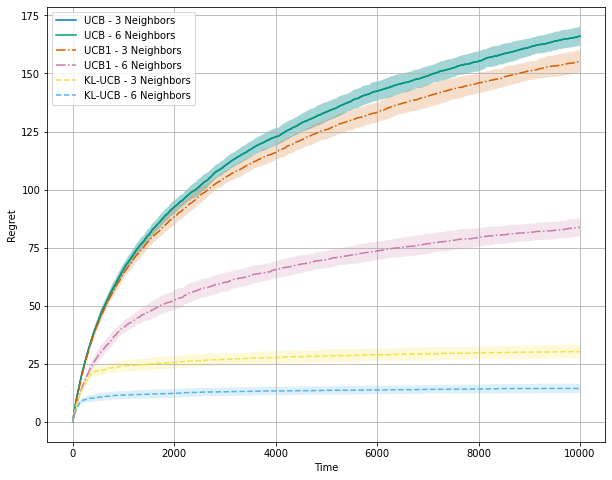

In [66]:
plt.figure(figsize=(10,8))

avg_6_1_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[0:3], axis=0)
avg_6_001_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[3:6], axis=0)
avg_3_1_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[6:9], axis=0)
avg_3_001_regret = np.mean(mean_regrets_over_all_runs_dist_ucb1[9:12], axis=0)
std_6_1_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[0:3], axis=0)
std_6_001_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[3:6], axis=0)
std_3_1_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[6:9], axis=0)
std_3_001_regret = np.mean(std_regrets_over_all_runs_dist_ucb1[9:12], axis=0)

avg_6_ucb_regret = np.mean(mean_regrets_over_all_runs_dist_ucb[0:6], axis=0)
avg_3_ucb_regret = np.mean(mean_regrets_over_all_runs_dist_ucb[6:12], axis=0)
std_6_ucb_regret = np.mean(std_regrets_over_all_runs_dist_ucb[0:6], axis=0)
std_3_ucb_regret = np.mean(std_regrets_over_all_runs_dist_ucb[6:12], axis=0)

avg_6_1_regret_kl = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[0:3], axis=0)
avg_6_001_regret_kl = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[3:6], axis=0)
avg_3_1_regret_kl = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[6:9], axis=0)
avg_3_001_regret_kl = np.mean(mean_regrets_over_all_runs_dist_kl_ucb[9:12], axis=0)
std_6_1_regret_kl = np.mean(std_regrets_over_all_runs_dist_kl_ucb[0:3], axis=0)
std_6_001_regret_kl = np.mean(std_regrets_over_all_runs_dist_kl_ucb[3:6], axis=0)
std_3_1_regret_kl = np.mean(std_regrets_over_all_runs_dist_kl_ucb[6:9], axis=0)
std_3_001_regret_kl = np.mean(std_regrets_over_all_runs_dist_kl_ucb[9:12], axis=0)

plt.plot(time_axis, avg_3_ucb_regret, label="UCB - 3 Neighbors")
plt.fill_between(time_axis, avg_3_ucb_regret-std_3_ucb_regret, avg_3_ucb_regret+std_3_ucb_regret,alpha=.2)
plt.plot(time_axis, avg_6_ucb_regret, label="UCB - 6 Neighbors")
plt.fill_between(time_axis, avg_6_ucb_regret-std_6_ucb_regret, avg_6_ucb_regret+std_6_ucb_regret,alpha=.2)

#plt.plot(time_axis, avg_3_1_regret, label="UCB1 Group 1")
#plt.fill_between(time_axis, avg_3_1_regret-std_3_1_regret, avg_3_1_regret+std_3_1_regret,alpha=.2)
plt.plot(time_axis, avg_3_001_regret, '-.',label="UCB1 - 3 Neighbors")
plt.fill_between(time_axis, avg_3_001_regret-std_3_001_regret, avg_3_001_regret+std_3_001_regret,alpha=.2)
#plt.plot(time_axis, avg_6_1_regret, label="UCB1 Group 3")
#plt.fill_between(time_axis, avg_6_1_regret-std_6_1_regret, avg_6_1_regret+std_6_1_regret,alpha=.2)
plt.plot(time_axis, avg_6_001_regret, '-.',label="UCB1 - 6 Neighbors")
plt.fill_between(time_axis, avg_6_001_regret-std_6_001_regret, avg_6_001_regret+std_6_001_regret,alpha=.2)

#plt.plot(time_axis, avg_3_1_regret_kl, '--', label="KL Group 1")
#plt.fill_between(time_axis, avg_3_1_regret_kl-std_3_1_regret_kl, avg_3_1_regret_kl+std_3_1_regret_kl,alpha=.2)
plt.plot(time_axis, avg_3_001_regret_kl, '--',label="KL-UCB - 3 Neighbors")
plt.fill_between(time_axis, avg_3_001_regret_kl-std_3_001_regret_kl, avg_3_001_regret_kl+std_3_001_regret_kl,alpha=.2)
#plt.plot(time_axis, avg_6_1_regret_kl, '--',label="KL Group 3")
#plt.fill_between(time_axis, avg_6_1_regret_kl-std_6_1_regret_kl, avg_6_1_regret_kl+std_6_1_regret_kl,alpha=.2)
plt.plot(time_axis, avg_6_001_regret_kl, '--',label="KL-UCB - 6 Neighbors")
plt.fill_between(time_axis, avg_6_001_regret_kl-std_6_001_regret_kl, avg_6_001_regret_kl+std_6_001_regret_kl,alpha=.2)


plt.xlabel("Time")
plt.ylabel("Regret")

plt.legend()
plt.grid()

plt.savefig("dist_comparison.pdf", bbox_inches='tight')